In [1]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.summarization import keywords
from gensim.summarization import summarize

model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [ ]:
# import pandas as pd

# df = pd.read_csv("training_set_rel3.tsv", sep="\t", encoding="ISO-8859-1")
# #df.head()

In [ ]:
# #t = df[df["essay_set"]==8]["essay"]
# i = 0
# for x in t:
#     if len(x)>5000:
#         f = open("./test/t_"+str(i)+".txt", 'w')
#         f.write(x)
#         f.close()
#         i+=1
# print(i)

In [74]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from summarization import Summarizer

summarizer = Summarizer("sample6")
sums = summarizer.summarize_all()

files = summarizer.files 
print(files)

for sum in sums:
    print(sum, len(sum))



['essay01.txt', 'essay02.txt', 'essay03.txt', 'essay04.txt', 'essay05.txt']
['Environment means all the natural surroundings such as land, air, water, plants, animals, solid material, wastes, sunlight, forests and other things.', 'However, now a day, some manmade technological advancement spoiling the environment in many ways which ultimately disturbs the balance or equilibrium of nature.', 'If we do anything in wrong way out of the discipline of nature, it disturbs the whole environment means atmosphere, hydrosphere and lithosphere.', 'The components of the natural environment are used as a resource however it is also exploited by the human being in order to fulfil some basic physical needs and purpose of life.', 'We should not challenge our natural resources and stop putting so much pollution or waste to the environment.', 'In examining the various myths, this paper will challenge the greater issue, can marriage survive infidelity?', 'There was a time when more smart-conscious decisi

In [75]:
corpus = []
d = dict()

i = 0
for sum in sums:
    for x in sum:
        corpus.append(x)
        d[x] = i
        i+=1
        
len(corpus)

58

In [ ]:
# sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
# sentence_president = 'The president greets the press in Chicago'.lower().split()

# model.wmdistance(sentence_obama, sentence_president)

In [76]:
# corpus = [
#     "Can you be more specific with your question?",
#     "Are you able to eliminate ambiguity from your question?",
#     "Could you be more specific?",
#     "Can you explain yourself more clearly?",
#     "Please be more specific",
#     "Will you restate your question more clearly?",
#     "Quick brown fox jumped over the lazy dog",
#     "The dog lay on the floor and the fox jumped over it",
#     "Unlike the dog, the fox was quick and brown and was able to jump over the dog",
#     "The dog was lazy and could not reach the fox which jumped over it",
#     "The dog could not match the fox's speed who easily jumped over it and disappeared"
# ]

data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    #res = []
    res = 0
    n = 0
    for word in sentence:
        try:
            res+=model[word]
            #res.append(model[word])
            n+=1
        except:
            pass
    res/=n
    #print(n)
    #for i in range(50-n):
    #    res.append([0]*300)
    res = np.array(res)
    #print(res.shape)
    data.append(res.reshape(-1))
    
data = np.array(data)
#data

In [ ]:
[0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0]
[1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0]

We need to maintain the originality of our environment to continue the life on the earth, the only place where life is possible till now in the whole universe.


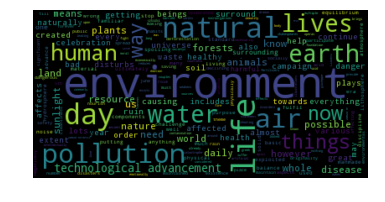

According to the American Association for Marriage and Family Therapy, common responses of the faithful partner may include: &ldquo;obsessively pondering details of the affair; continuously watching for further signs of betrayal; and physiological hyperarousal, flashbacks and intrusive images.&rdquo; The victim may fixate on discovering the reason for the infidelity and may attempt to change her physical appearance according to what she believes her spouse expects in a partner.


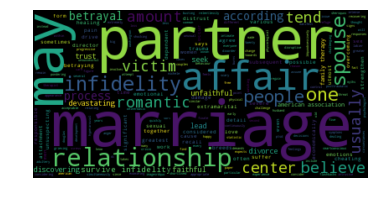

In [101]:
NUM_CLUSTERS = 2

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=125) #euclidean_distance #cosine_distance
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(kclusterer.means())

import re
from collections import Counter
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))
    cnt = Counter(text)
    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()
    
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    m = 100
    l = 0
    for k in range(len(data)):
        t = euclidean_distance(data[k], kclusterer.means()[j])
        if t<m:
            m=t
            l=k
    print(corpus[l])
    plt.show()

In [84]:
len(kclusterer.means()[0])

300

In [85]:
len(data)

58

In [92]:
for j in range(NUM_CLUSTERS):
    m = 100
    i = 0
    for k in range(len(data)):
        t = euclidean_distance(data[k], kclusterer.means()[j])
        if t<m:
            m=t
            i=k
    print(corpus[i])

We need to maintain the originality of our environment to continue the life on the earth, the only place where life is possible till now in the whole universe.
According to the American Association for Marriage and Family Therapy, common responses of the faithful partner may include: &ldquo;obsessively pondering details of the affair; continuously watching for further signs of betrayal; and physiological hyperarousal, flashbacks and intrusive images.&rdquo; The victim may fixate on discovering the reason for the infidelity and may attempt to change her physical appearance according to what she believes her spouse expects in a partner.


In [63]:
weights = [0.5,-0.5]

In [69]:
i = 0
for essay in sums:
    res = 0
    for sentance in essay:
        k = assigned_clusters[d[sentance]]
        #print(k)
        res+= weights[k]
    print(files[i], round(res,1))
    i+=1

essay01.txt 0.5
essay02.txt -4.0
essay03.txt -1.0
essay04.txt 0.0
essay05.txt 1.0
